In [1]:
!pip install "chronos-forecasting>=2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.6 MB/s eta 0:00:00


In [2]:
import os
import sys
import time
import warnings

from chronos import Chronos2Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import torch
from tqdm import tqdm
import xgboost as xgb

In [3]:
warnings.filterwarnings("ignore", module="chronos")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*pin_memory.*")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BATCH_MODE = True

BASE_PATH = '/content/drive/My Drive/Projects/inventory'
INPUT_FILE = os.path.join(BASE_PATH, 'train.csv')

In [6]:
LEAD_TIME_MEAN = 14
LEAD_TIME_STD = 5
SERVICE_LEVEL = 0.95
HOLDING_COST = 0.005
STOCKOUT_COST = 5
ORDERING_COST = 7

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {DEVICE.upper()}")

Running on device: CUDA


In [7]:
def plot_adf_benchmark(adf_stat, critical_values, title='Stationarity Test Result'):
    """Visualize ADF test results comparing test statistic against critical values."""
    labels = ['ADF Statistic'] + list(critical_values.keys())
    values = [adf_stat] + list(critical_values.values())
    colors = ['#1f77b4'] + ['#d62728' for _ in critical_values]

    plt.figure(figsize=(10, 6))

    bars = plt.barh(labels, values, color=colors, alpha=0.8)

    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.4f}',
                 va='center', ha='left' if bar.get_width() > 0 else 'right',
                 fontweight='bold')

    plt.axvline(critical_values['5%'], color='green', linestyle='--', linewidth=2, label='5% Confidence Threshold')

    plt.title(title, fontsize=14)
    plt.xlabel('Test Statistic Value (More Negative is Better)')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)

    status = 'STATIONARY' if adf_stat < critical_values['5%'] else 'NON-STATIONARY'
    plt.figtext(0.5, -0.05, f'Result: {status}',
                ha='center', fontsize=12, bbox={'facecolor':'orange', 'alpha':0.2, 'pad':5})

    plt.tight_layout()
    plt.show()

In [8]:
def calculate_safety_stock(mean_forecast, forecast_error_std_dev):
    z_score = stats.norm.ppf(SERVICE_LEVEL)

    # Compound Variance Formula: Sigma_DL = sqrt( L * Sigma_D^2 + D^2 * Sigma_L^2 )
    demand_variance_component = LEAD_TIME_MEAN * (forecast_error_std_dev ** 2)
    supply_variance_component = (mean_forecast ** 2) * (LEAD_TIME_STD ** 2)
    combined_std_dev = np.sqrt(demand_variance_component + supply_variance_component)

    return z_score * combined_std_dev

In [9]:
def calculate_policy(mean_forecast, forecast_error_std_dev):
    """Calculate inventory policy parameters accounting for Demand and Supply variability."""
    z_score = stats.norm.ppf(SERVICE_LEVEL)

    safety_stock = calculate_safety_stock(mean_forecast, forecast_error_std_dev)

    reorder_point = (mean_forecast * LEAD_TIME_MEAN) + safety_stock

    annual_demand = mean_forecast * 365

    order_quantity = np.sqrt((2 * annual_demand * ORDERING_COST) / (HOLDING_COST * 365))

    return {
        'safety_stock': round(safety_stock, 2),
        'reorder_point': round(reorder_point, 2),
        'order_quantity': round(order_quantity, 2)
    }

In [10]:
def run_dynamic_simulation(forecast_series, actual_demand, forecast_error_std_dev, verbose=False):
    """Simulate inventory operations with Stochastic Lead Times."""
    n_days = len(actual_demand)
    z_score = stats.norm.ppf(SERVICE_LEVEL)

    avg_daily_demand = np.mean(forecast_series)

    safety_stock = calculate_safety_stock(avg_daily_demand, forecast_error_std_dev)

    order_quantity = np.sqrt((2 * avg_daily_demand * 365 * ORDERING_COST) / (HOLDING_COST * 365))

    order_quantity = max(1.0, round(order_quantity, 0))

    initial_lookahead = sum(forecast_series[:LEAD_TIME_MEAN])
    inventory = initial_lookahead + safety_stock

    pipeline_orders = [] # tuples of (arrival_day, qty)

    total_holding_cost = 0.0
    total_stockout_cost = 0.0
    total_lost_sales = 0.0

    if verbose:
        print(f'\nDynamic Simulation Start')
        print(f'SS (Dynamic): {safety_stock:.2f} | EOQ: {order_quantity}')
        print(f'{"Day":<5} | {"Fcst(LT)":<9} | {"DynROP":<8} | {"InvPos":<8} | {"NetInv":<8} | {"Demand":<8} | {"Lost":<6} | {"Act.LT":<6}')
        print('-' * 98)

    for day in range(n_days):
        arrived_qty = sum([qty for arr_day, qty in pipeline_orders if arr_day == day])
        inventory += arrived_qty
        pipeline_orders = [o for o in pipeline_orders if o[0] > day]

        demand = actual_demand[day]
        if inventory >= demand:
            sales = demand
            inventory -= demand
            lost_sales = 0
        else:
            sales = inventory
            lost_sales = demand - inventory
            inventory = 0

        total_lost_sales += lost_sales

        daily_holding = inventory * HOLDING_COST
        daily_stockout = lost_sales * STOCKOUT_COST
        total_holding_cost += daily_holding
        total_stockout_cost += daily_stockout

        # reviewing ordering
        start_idx = day + 1
        end_idx = start_idx + LEAD_TIME_MEAN

        if end_idx <= n_days:
            expected_demand_during_lt = sum(forecast_series[start_idx : end_idx])
        else:
            available_days = n_days - start_idx
            if available_days > 0:
                known = sum(forecast_series[start_idx:])
                # ordering partially for the period after the test window
                padded = avg_daily_demand * (LEAD_TIME_MEAN - available_days)
                expected_demand_during_lt = known + padded
            else:
                # ordering for the period after the test window
                expected_demand_during_lt = avg_daily_demand * LEAD_TIME_MEAN

        dynamic_rop = expected_demand_during_lt + safety_stock

        on_order_qty = sum([qty for _, qty in pipeline_orders])
        inventory_position = inventory + on_order_qty

        sampled_lt_str = '-'
        if inventory_position <= dynamic_rop:
            # sample lead time
            actual_lt_float = np.random.normal(LEAD_TIME_MEAN, LEAD_TIME_STD)
            actual_lt = int(max(1, round(actual_lt_float)))

            arrival_day = day + actual_lt
            pipeline_orders.append((arrival_day, order_quantity))
            sampled_lt_str = str(actual_lt)

        if verbose:
             print(f'{day:<5} | {expected_demand_during_lt:<9.1f} | {dynamic_rop:<8.1f} | {inventory_position:<8.1f} | {inventory:<8.1f} | {demand:<8.1f} | {lost_sales:<6.1f} | {sampled_lt_str:<6}')

    total_cost = total_holding_cost + total_stockout_cost
    service_level = 1 - (total_lost_sales / (sum(actual_demand)+0.01))

    if verbose:
        print('\n')
        print(f'Total Holding:  ${total_holding_cost:,.2f}')
        print(f'Total Stockout: ${total_stockout_cost:,.2f}')
        print(f'TOTAL COST:     ${total_cost:,.2f}')
        print(f'Service Level:  {service_level:.2%}')
        print('\n')

    return round(total_holding_cost, 2), round(total_stockout_cost, 2), round(total_cost, 2), service_level

In [11]:
def get_xgboost_forecast(train_df, test_df, verbose=True):
    """Generate forecast using XGBoost"""

    def create_features(df):
        df = df.copy()
        df['day_of_week'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['day_of_year'] = df['date'].dt.dayofyear
        df['year'] = df['date'].dt.year
        return df

    X_train = create_features(train_df)

    # add the sales from a year ago as a feature
    lookup = train_df[['date', 'sales']].copy()
    lookup['match_date'] = lookup['date'] + pd.Timedelta(days=365)

    X_train = X_train.merge(lookup[['match_date', 'sales']],
                            left_on='date', right_on='match_date',
                            how='left', suffixes=('', '_lag365'))
    X_train.rename(columns={'sales_lag365': 'lag_365'}, inplace=True)

    X_test = create_features(test_df)
    X_test = X_test.merge(lookup[['match_date', 'sales']],
                          left_on='date', right_on='match_date',
                          how='left', suffixes=('', '_lag365'))
    X_test.rename(columns={'sales_lag365': 'lag_365'}, inplace=True)

    # Drop rows where lag is unavailable (first year of training)
    X_train.dropna(subset=['lag_365'], inplace=True)

    features = ['day_of_week', 'month', 'day_of_year', 'year', 'lag_365']
    target = 'sales'

    xgb_device = "cuda" if DEVICE == "cuda" else "cpu"

    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01,
                             max_depth=5, early_stopping_rounds=50, n_jobs=-1,
                             device=xgb_device)

    # validation split
    split_idx = int(len(X_train) * 0.9)
    X_tr = X_train.iloc[:split_idx]
    X_val = X_train.iloc[split_idx:]

    # train on 90% to measure Sigma and find optimal trees
    model.fit(X_tr[features], X_tr[target],
              eval_set=[(X_tr[features], X_tr[target]), (X_val[features], X_val[target])],
              verbose=False)

    # calculate residuals on validation set to estimate uncertainty
    val_preds = model.predict(X_val[features])
    residuals = X_val[target] - val_preds
    sigma = np.sqrt(np.mean(residuals ** 2))

    if verbose:
        print(f"XGBoost Trained. Validation RMSE: {sigma:.2f}")

    # retrain on 100% data
    optimal_trees = model.best_iteration
    model.set_params(early_stopping_rounds=None, n_estimators=optimal_trees)

    model.fit(X_train[features], X_train[target], verbose=False)

    forecast = model.predict(X_test[features])

    return forecast, sigma

In [18]:
def get_trend_adjusted_baseline(train_df, valid_df, verbose=True):
    """
    Generate baseline forecast using smoothed seasonal patterns and a
    Moving Average Trend (Rolling YoY).
    """

    def calculate_forecast_on_history(history_df, target_dates_df):
        # smooth the history to reduce daily noise for trend calculation using a 7-day rolling mean
        df_smooth = history_df.copy()
        df_smooth['sales_smooth'] = df_smooth['sales'].rolling(window=7, min_periods=1, center=True).mean()

        last_date = df_smooth['date'].max()

        # calculate trend using a moving average Approach
        # look at the last 90 days, compare them to the same days 1 year ago, take the average of those ratios
        trend_window_days = 90
        split_date = last_date - pd.Timedelta(days=trend_window_days)

        recent_df = df_smooth[df_smooth['date'] > split_date].copy()

        # data from 1 year ago for the same window
        recent_df['match_date_prev'] = recent_df['date'] - pd.Timedelta(days=365)

        # self-merge to align "Current" vs "Last Year"
        merged = recent_df.merge(
            df_smooth[['date', 'sales_smooth']],
            left_on='match_date_prev',
            right_on='date',
            how='inner',
            suffixes=('_curr', '_prev')
        )

        # daily ratios, avoiding division by zero
        valid_rows = merged[merged['sales_smooth_prev'] > 0]

        if len(valid_rows) > 10:
            ratios = valid_rows['sales_smooth_curr'] / valid_rows['sales_smooth_prev']
            # remove extreme outliers
            ratios = ratios[ratios.between(0.5, 2.0)]
            trend_factor = ratios.mean()
        else:
            trend_factor = 1.0

        # cap trend to avoid explosions
        trend_factor = min(max(trend_factor, 0.7), 1.3)

        # create seasonality profile
        # exclude the immediate trend window from the seasonality shape to avoid double counting
        base_df = history_df[history_df['date'] <= split_date].copy()
        base_df['day_of_year'] = base_df['date'].dt.dayofyear
        # handle leap years
        base_df.loc[base_df['day_of_year'] == 366, 'day_of_year'] = 365

        # raw daily profile
        raw_profile = base_df.groupby('day_of_year')['sales'].mean()

        # apply moving average to the seasonality profile itself (smooth out jagged days)
        seasonal_profile = raw_profile.rolling(window=7, min_periods=1, center=True).mean()

        # fill any gaps
        overall_mean = base_df['sales'].mean()
        seasonal_profile = seasonal_profile.fillna(overall_mean)

        # generate forecast
        target_df = target_dates_df.copy()
        target_df['day_of_year'] = target_df['date'].dt.dayofyear
        target_df.loc[target_df['day_of_year'] == 366, 'day_of_year'] = 365

        forecast_values = target_df['day_of_year'].map(seasonal_profile).fillna(overall_mean).values * trend_factor

        return forecast_values, trend_factor

    # hold-out validation for sigma
    split_idx = int(len(train_df) * 0.9)
    train_tr = train_df.iloc[:split_idx].copy()
    train_val = train_df.iloc[split_idx:].copy()

    val_forecast, _ = calculate_forecast_on_history(train_tr, train_val)
    residuals = train_val['sales'].values - val_forecast
    sigma = np.sqrt(np.mean(residuals ** 2))

    if verbose:
        print(f"Baseline Validated. Sigma (RMSE): {sigma:.2f}")

    # final forecast
    final_forecast, final_trend = calculate_forecast_on_history(train_df, valid_df)

    return final_forecast, sigma, final_trend

In [21]:
def run_analysis_for_pair(train_df, test_df, pipeline, verbose=True, plot=True):
    """Run full analysis comparing Baseline vs XGBoost vs Chronos 2."""
    results = {}
    actual_demand = test_df['sales'].values
    total_vol = np.sum(actual_demand) + 1e-6

    if verbose: print('\n--- 1. Baseline Simulation ---')
    baseline_fcst, baseline_std, _ = get_trend_adjusted_baseline(train_df, test_df, verbose=verbose)
    baseline_holding, baseline_stockout, baseline_cost, baseline_sl = run_dynamic_simulation(baseline_fcst, actual_demand, baseline_std, verbose=verbose)
    baseline_r2 = r2_score(actual_demand, baseline_fcst)
    baseline_bias = np.sum(baseline_fcst - actual_demand)

    results['baseline_r2'] = baseline_r2
    results['baseline_rmse'] = np.sqrt(mean_squared_error(actual_demand, baseline_fcst))
    results['baseline_bias_pct'] = baseline_bias / total_vol
    results['baseline_holding_cost'] = baseline_holding
    results['baseline_stockout_cost'] = baseline_stockout
    results['baseline_cost'] = baseline_cost
    results['baseline_sl'] = baseline_sl

    if verbose: print('\n--- 2. XGBoost Simulation ---')
    xgb_fcst, xgb_std = get_xgboost_forecast(train_df, test_df, verbose=verbose)

    if plot:
        plt.figure(figsize=(15, 6))
        plt.plot(test_df['date'], actual_demand, label='Actual', color='black', alpha=0.3)
        plt.plot(test_df['date'], baseline_fcst, label='Baseline', color='green', linestyle='--')
        plt.plot(test_df['date'], xgb_fcst, label='XGBoost', color='orange', linewidth=2)
        plt.title('Forecast Comparison: Baseline vs XGBoost')
        plt.legend()
        plt.show()

    xgb_holding, xgb_stockout, xgb_cost, xgb_sl = run_dynamic_simulation(xgb_fcst, actual_demand, xgb_std, verbose=verbose)
    xgb_r2 = r2_score(actual_demand, xgb_fcst)
    xgb_bias = np.sum(xgb_fcst - actual_demand)

    results['xgb_r2'] = xgb_r2
    results['xgb_rmse'] = np.sqrt(mean_squared_error(actual_demand, xgb_fcst))
    results['xgb_bias_pct'] = xgb_bias / total_vol
    results['xgb_holding_cost'] = xgb_holding
    results['xgb_stockout_cost'] = xgb_stockout
    results['xgb_cost'] = xgb_cost
    results['xgb_sl'] = xgb_sl

    if verbose: print('\n--- 3. Chronos 2 Simulation ---')
    context_tensor = torch.tensor(train_df['sales'].values)
    context_tensor = context_tensor.unsqueeze(0).unsqueeze(0) # Make it (1, 1, Length)
    forecast_result = pipeline.predict(context_tensor, len(test_df))
    batch_item_forecast = forecast_result[0]
    forecast_samples = batch_item_forecast.cpu().numpy()
    if forecast_samples.ndim == 3:
        forecast_samples = forecast_samples[0]

    # calculate mean and std directly from the probabilistic samples
    daily_means = np.mean(forecast_samples, axis=0)
    chronos_sigma = np.mean(np.std(forecast_samples, axis=0))

    chronos_holding, chronos_stockout, chronos_cost, chronos_sl = run_dynamic_simulation(daily_means, actual_demand, chronos_sigma, verbose=verbose)
    chronos_r2 = r2_score(actual_demand, daily_means)
    chronos_bias = np.sum(daily_means - actual_demand)

    results['chronos_r2'] = chronos_r2
    results['chronos_rmse'] = np.sqrt(mean_squared_error(actual_demand, daily_means))
    results['chronos_bias_pct'] = chronos_bias / total_vol
    results['chronos_holding_cost'] = chronos_holding
    results['chronos_stockout_cost'] = chronos_stockout
    results['chronos_cost'] = chronos_cost
    results['chronos_sl'] = chronos_sl

    # final comparison
    xgb_savings = baseline_cost - xgb_cost
    xgb_pct = (xgb_savings / baseline_cost * 100) if baseline_cost > 0 else 0

    chronos_savings = baseline_cost - chronos_cost
    chronos_pct = (chronos_savings / baseline_cost * 100) if baseline_cost > 0 else 0

    chronos_vs_xgb_savings = xgb_cost - chronos_cost
    chronos_vs_xgb_pct = (chronos_vs_xgb_savings / xgb_cost * 100) if xgb_cost > 0 else 0

    if verbose:
        print('FINAL RESULTS')
        print(f'Accuracy (R2):  Base={baseline_r2:.3f} | XGB={xgb_r2:.3f} | Chronos={chronos_r2:.3f}')
        print(f'Baseline Cost: ${baseline_cost:,.2f}')
        print(f'XGBoost Cost:  ${xgb_cost:,.2f}  (Savings vs Base: ${xgb_savings:,.0f} | {xgb_pct:.1f}%)')
        print(f'Chronos 2 Cost: ${chronos_cost:,.2f}  (Savings vs Base: ${chronos_savings:,.0f} | {chronos_pct:.1f}%)')
        print(f'                                  (Savings vs XGB:  ${chronos_vs_xgb_savings:,.0f} | {chronos_vs_xgb_pct:.1f}%)')

    return results

In [22]:
print('Phase 1: Data Preparation')
print(f'Loading raw data from {INPUT_FILE}...')
df_all = pd.read_csv(INPUT_FILE)
df_all.columns = df_all.columns.str.strip()
if 'store' not in df_all.columns and 'strore' in df_all.columns:
    df_all.rename(columns={'strore': 'store'}, inplace=True)
df_all['date'] = pd.to_datetime(df_all['date'])

print(f'Initializing Chronos 2 Pipeline on {DEVICE.upper()}...')
pipeline = Chronos2Pipeline.from_pretrained(
    'amazon/chronos-2',
    device_map=DEVICE,
    torch_dtype=torch.bfloat16,
)

if BATCH_MODE:
    print('\nBATCH MODE ENABLED')
    pairs = df_all[['store', 'item']].drop_duplicates().values
    print(f'Found {len(pairs)} store-item pairs.')

    results_list = []
    start_time = time.time()

    for store, item in tqdm(pairs, desc="Processing Pairs", unit="pair"):

        subset = df_all[(df_all['store'] == store) & (df_all['item'] == item)].sort_values('date').copy()
        train_subset = subset[subset['date'].dt.year < 2017].copy()
        test_subset = subset[subset['date'].dt.year == 2017].copy()

        try:
            res = run_analysis_for_pair(train_subset, test_subset, pipeline, verbose=False, plot=False)
            res['store'] = store
            res['item'] = item
            results_list.append(res)
        except Exception as e:
            tqdm.write(f'Error processing Store {store}, Item {item}: {e}')

    results_df = pd.DataFrame(results_list)

    cols = ['baseline_cost', 'xgb_cost', 'chronos_cost']
    avgs = results_df[cols].mean()

    print('\n\nBATCH RESULTS (Averages)')
    print(f'Baseline Cost:  ${avgs["baseline_cost"]:,.2f}')
    print(f'XGBoost Cost:   ${avgs["xgb_cost"]:,.2f}')
    print(f'Chronos 2 Cost: ${avgs["chronos_cost"]:,.2f}')

    results_df.to_csv(os.path.join(BASE_PATH, 'batch_results_xgb_c2.csv'), index=False)
else:
    print('\n--- SINGLE ITEM MODE ---')
    subset = df_all[(df_all['store'] == 1) & (df_all['item'] == 1)].sort_values('date').copy()
    train_subset = subset[subset['date'].dt.year < 2017].copy()
    test_subset = subset[subset['date'].dt.year == 2017].copy()

    run_analysis_for_pair(train_subset, test_subset, pipeline, verbose=True, plot=True)

Phase 1: Data Preparation
Loading raw data from /content/drive/My Drive/Projects/inventory/train.csv...
Initializing Chronos 2 Pipeline on CUDA...

BATCH MODE ENABLED
Found 500 store-item pairs.


Processing Pairs: 100%|██████████| 500/500 [08:45<00:00,  1.05s/pair]



BATCH RESULTS (Averages)
Baseline Cost:  $1,875.18
XGBoost Cost:   $1,764.25
Chronos 2 Cost: $1,531.27



             SUMMARY             

1. GLOBAL IMPACT (Total Inventory Costs)
   Baseline:    $937,589 (Holding: $544,203, Stockout: $393,386)
   XGBoost:     $882,123 (Holding: $580,112, Stockout: $302,011)
   Chronos 2:   $765,633 (Holding: $654,763, Stockout: $110,870)

2. OPERATIONAL VIEW (Average Cost Per Item)
   Baseline:    $1,875.18 / item
   XGBoost:     $1,764.25 / item
   Chronos 2:   $1,531.27 / item

3. COST SAVINGS ANALYSIS
   XGBoost vs Baseline:
      Total Savings:    $55,466
      Avg per Item:     $110.93
      Reduction:        5.92%
   Chronos 2 vs Baseline:
      Total Savings:    $171,956
      Avg per Item:     $343.91
      Reduction:        18.34%
   Chronos 2 vs XGBoost:
      Total Savings:    $116,490
      Avg per Item:     $232.98
      Reduction:        13.21%

4. SERVICE LEVELS (Target: 95%)
   Baseline:    99.17%
   XGBoost:     99.30%
   Chronos 2:   99.75%

5. FORECAST ACCURACY (Average R2 Score)
   Baseline:    0.3777
   XGBoost:     0.6131
   Chron

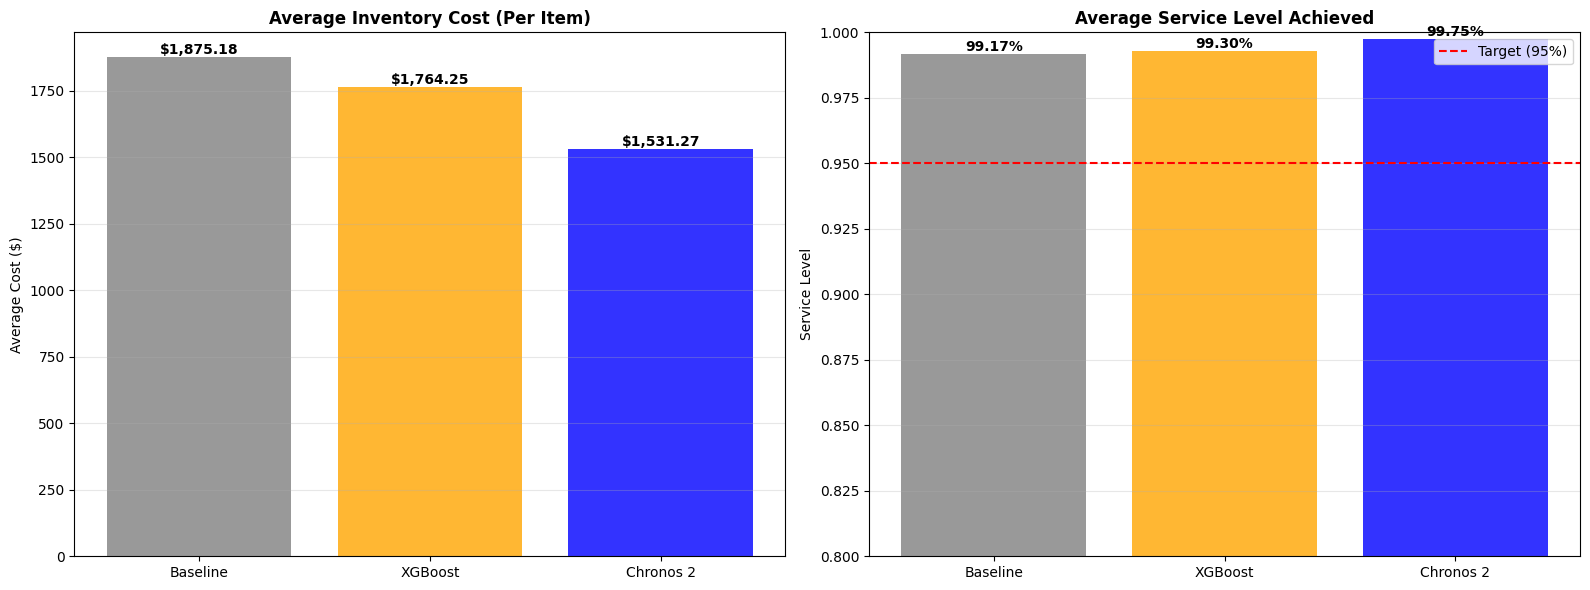

In [25]:
if 'results_df' not in locals():
    results_path = os.path.join(BASE_PATH, 'batch_results_xgb_c2.csv')
    results_df = pd.read_csv(results_path)
    print(f"Loaded results from {results_path}")

# aggregates
total_baseline = results_df['baseline_cost'].sum()
total_xgb = results_df['xgb_cost'].sum()
total_chronos = results_df['chronos_cost'].sum()

total_baseline_holding = results_df['baseline_holding_cost'].sum()
total_baseline_stockout = results_df['baseline_stockout_cost'].sum()
total_xgb_holding = results_df['xgb_holding_cost'].sum()
total_xgb_stockout = results_df['xgb_stockout_cost'].sum()
total_chronos_holding = results_df['chronos_holding_cost'].sum()
total_chronos_stockout = results_df['chronos_stockout_cost'].sum()

# averages
avg_baseline = results_df['baseline_cost'].mean()
avg_xgb = results_df['xgb_cost'].mean()
avg_chronos = results_df['chronos_cost'].mean()

avg_sl_baseline = results_df['baseline_sl'].mean()
avg_sl_xgb = results_df['xgb_sl'].mean()
avg_sl_chronos = results_df['chronos_sl'].mean()

avg_r2_baseline = results_df['baseline_r2'].mean()
avg_r2_xgb = results_df['xgb_r2'].mean()
avg_r2_chronos = results_df['chronos_r2'].mean()

avg_rmse_baseline = results_df['baseline_rmse'].mean()
avg_rmse_xgb = results_df['xgb_rmse'].mean()
avg_rmse_chronos = results_df['chronos_rmse'].mean()

# savings %
pct_sav_xgb = (total_baseline - total_xgb) / total_baseline
pct_sav_chronos = (total_baseline - total_chronos) / total_baseline
pct_sav_chronos_vs_xgb = (total_xgb - total_chronos) / total_xgb

print("\n" + "="*60)
print("             SUMMARY             ")
print("="*60)

print(f"\n1. GLOBAL IMPACT (Total Inventory Costs)")
print(f"   Baseline:    ${total_baseline:,.0f} (Holding: ${total_baseline_holding:,.0f}, Stockout: ${total_baseline_stockout:,.0f})")
print(f"   XGBoost:     ${total_xgb:,.0f} (Holding: ${total_xgb_holding:,.0f}, Stockout: ${total_xgb_stockout:,.0f})")
print(f"   Chronos 2:   ${total_chronos:,.0f} (Holding: ${total_chronos_holding:,.0f}, Stockout: ${total_chronos_stockout:,.0f})")

print(f"\n2. OPERATIONAL VIEW (Average Cost Per Item)")
print(f"   Baseline:    ${avg_baseline:,.2f} / item")
print(f"   XGBoost:     ${avg_xgb:,.2f} / item")
print(f"   Chronos 2:   ${avg_chronos:,.2f} / item")

print(f"\n3. COST SAVINGS ANALYSIS")
print(f"   XGBoost vs Baseline:")
print(f"      Total Savings:    ${total_baseline - total_xgb:,.0f}")
print(f"      Avg per Item:     ${avg_baseline - avg_xgb:,.2f}")
print(f"      Reduction:        {pct_sav_xgb:.2%}")

print(f"   Chronos 2 vs Baseline:")
print(f"      Total Savings:    ${total_baseline - total_chronos:,.0f}")
print(f"      Avg per Item:     ${avg_baseline - avg_chronos:,.2f}")
print(f"      Reduction:        {pct_sav_chronos:.2%}")

print(f"   Chronos 2 vs XGBoost:")
print(f"      Total Savings:    ${total_xgb - total_chronos:,.0f}")
print(f"      Avg per Item:     ${avg_xgb - avg_chronos:,.2f}")
print(f"      Reduction:        {pct_sav_chronos_vs_xgb:.2%}")

print(f"\n4. SERVICE LEVELS (Target: {SERVICE_LEVEL:.0%})")
print(f"   Baseline:    {avg_sl_baseline:.2%}")
print(f"   XGBoost:     {avg_sl_xgb:.2%}")
print(f"   Chronos 2:   {avg_sl_chronos:.2%}")

print(f"\n5. FORECAST ACCURACY (Average R2 Score)")
print(f"   Baseline:    {avg_r2_baseline:.4f}")
print(f"   XGBoost:     {avg_r2_xgb:.4f}")
print(f"   Chronos 2:   {avg_r2_chronos:.4f}")

print(f"\n6. FORECAST ERROR (RMSE)")
print(f"   Baseline:    {avg_rmse_baseline:.4f}")
print(f"   XGBoost:     {avg_rmse_xgb:.4f}")
print(f"   Chronos 2:   {avg_rmse_chronos:.4f}")
print("="*60 + "\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# average cost per Item
costs = [avg_baseline, avg_xgb, avg_chronos]
labels = ['Baseline', 'XGBoost', 'Chronos 2']
colors = ['gray', 'orange', 'blue']

bars = ax[0].bar(labels, costs, color=colors, alpha=0.8)
ax[0].set_title('Average Inventory Cost (Per Item)', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Average Cost ($)')
ax[0].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2., height,
               f'${height:,.2f}',
               ha='center', va='bottom', fontweight='bold')

# service levels
sls = [avg_sl_baseline, avg_sl_xgb, avg_sl_chronos]
bars_sl = ax[1].bar(labels, sls, color=colors, alpha=0.8)
ax[1].axhline(y=SERVICE_LEVEL, color='red', linestyle='--', label=f'Target ({SERVICE_LEVEL:.0%})')
ax[1].set_title('Average Service Level Achieved', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Service Level')
ax[1].set_ylim(0.8, 1.0)
ax[1].legend()
ax[1].grid(axis='y', alpha=0.3)

for bar in bars_sl:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2%}',
               ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

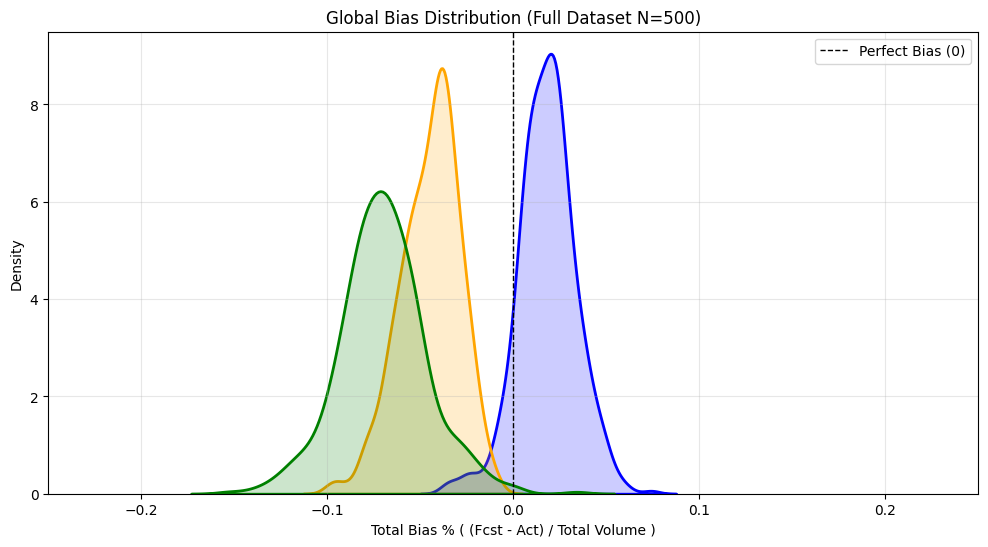


BIAS SUMMARY STATISTICS
      Baseline  XGBoost  Chronos
mean    -7.02%   -4.48%    1.80%
std      2.35%    1.60%    1.55%
50%     -7.05%   -4.22%    1.82%


In [28]:
bias_df = results_df[['store', 'item', 'baseline_bias_pct', 'xgb_bias_pct', 'chronos_bias_pct']].copy()
bias_df.rename(columns={
    'baseline_bias_pct': 'Baseline',
    'xgb_bias_pct': 'XGBoost',
    'chronos_bias_pct': 'Chronos'
}, inplace=True)
melted = bias_df.melt(id_vars=['store', 'item'], var_name='Model', value_name='Bias_Pct')

plt.figure(figsize=(12, 6))

sns.kdeplot(data=melted, x='Bias_Pct', hue='Model', fill=True, alpha=0.2, linewidth=2,
            palette={'Baseline': 'green', 'XGBoost': 'orange', 'Chronos': 'blue'})

plt.axvline(0, color='black', linestyle='--', linewidth=1, label='Perfect Bias (0)')
plt.title(f'Global Bias Distribution (Full Dataset N={len(bias_df)})')
plt.xlabel('Total Bias % ( (Fcst - Act) / Total Volume )')
plt.xlim(-0.25, 0.25)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*50)
print("BIAS SUMMARY STATISTICS")
print("="*50)
print(bias_df[['Baseline', 'XGBoost', 'Chronos']].describe().loc[['mean', 'std', '50%']].to_string(float_format="{:.2%}".format))
print("="*50)